# Chunking Subnet Benchmark

## Introduction

Like before, we setup the typical RAG pipeline for answering multiple choice questions that require context from a fictional book to answer. High quality questions were created from Claude's 3.5 sonnet model for each chapter of the book.

We did use the same novel as before (~250k tokens), as it made it easier to manually check question and retrieval quality during early stage experimentation. The questions this time around are harder to answer without the proper context, and we found that `gpt-4o-mini` would consistently get only around ~30% of the questions correct. This is what we use as the baseline for the benchmark. 

## Methodology

1) Chunking
    - Each chunker chunked each chapter of the book individually, these chunks were then embedded individually and stored
    in Pinecone for later use.
    - Each chunker had a different namespace to ensure that different chunks were not mixed up.
3) Retrieval (done for each question, using a combination of a vector database and reranker): 
    - Query the vector database, using the question as the embedding, for the top `rerank_buffer_size` chunks for a given question.
    - Pass all `rerank_buffer_size` chunks to a reranker (Cohere or Pinecone)
    - Select the top `top_k` chunks from the reranker to be used as relevant context for the question
        - We found that reranking greatly improved the retrieval process: without reranking, we were seeing as much as 75% of questions having irrelevant context.
        - Thus, we used Cohere's reranker with the same parameters for all chunk methods in this benchmark.
3) Question Answering (Benchmark):
    - For each question: pass question, context retrieved from before, and answer choices to a language model (in this case, "gpt-4o-mini")
    - Score the language model for each question (correct or incorrect) based on whether it chose the correct answer choice out of 8 answers.
    - repeat for all questions; percent accuracy is the main metric for this benchmark.

![Diagram explaining chunking benchmark](../assets/method.png)

### Notes

- For the Cohere reranking step, we made sure to set `max_chunks_per_doc=1` to force the reranker to use the chunks we gave it, rather than chunking each chunk again:

In [ ]:
import cohere
import os
from dotenv import load_dotenv

load_dotenv()

co = cohere.Client(api_key=os.getenv("CO_API_KEY"))

k = 3

res = co.rerank(
    query="What is the meaning of life?",
    documents=["The meaning of life is 42", "There is no meaning of life", "Happiness is the meaning of life"],
    model="rerank-english-v3.0",
    top_n=k,
    max_chunks_per_doc=1 # this makes sure the reranker only uses the chunks we give it and does not further subdivide
)

print(res)

- We did some simple preprocessing to the text, demoed below. We made sure to remove newlines within sentences, and remove extra spaces, leading and trailing spaces, and spaces after ' and before .,-’"

In [ ]:
from nltk.tokenize import sent_tokenize
import regex as re

def clean_text(text: str) -> str:
  sentences = sent_tokenize(text)

  # Remove newlines within sentences
  cleaned_sentences = [sentence.replace('\n', ' ') for sentence in sentences]

  def clean_sent(sentence):
    # Remove extra spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    # Remove leading and trailing spaces
    sentence = sentence.strip()
    # Remove spaces after ' and before ".,-’"
    sentence = re.sub(r'’ ', '', sentence)
    sentence = re.sub(r' ’', '', sentence)
    sentence = re.sub(r' \.', '', sentence)
    sentence = re.sub(r' \,', '', sentence)
    sentence = re.sub(r' \-', '', sentence)

    return sentence

  # for each sentence, clean it and join together
  cleaned_text = '\n'.join([clean_sent(sentence) for sentence in cleaned_sentences])
  return cleaned_text

## Chunk stats

| Method | Compute Time (s) | Avg Size | Median Size | Max Size | Min Size | Std Dev | Num Chunks | Cost |
|--------|------------|----------------|-------------------|----------------|----------------|---------|------------|------|
| unstructured.io | 548.42 | 256.401 | 323 | 421 | 2 | 128.112 | 1381 | $0.01 |
| ai21.com |113.297 | 132.097 | 115 | 435 | 1 | 103.92 | 2674 | $0.039 |
| chunking.com | 206.33 | 290.394 | 316 | 404 | 3 | 93.6567 | 2024 | **$0.0048** |

Above is some standard statistics for the chunks. Because [AI21's text segmentation API](https://docs.ai21.com/reference/text-segmentation-ref) does not allow for a `max_chunk_size` parameter we set the chunk size to 400 tokens to match the distribution better. Similarly, [Unstructured.io's chunker](https://docs.unstructured.io/open-source/core-functionality/chunking) uses characters rather than tokens as a metric, so we used a static multiplier of 4 to get a `max_characters` size of 1600.

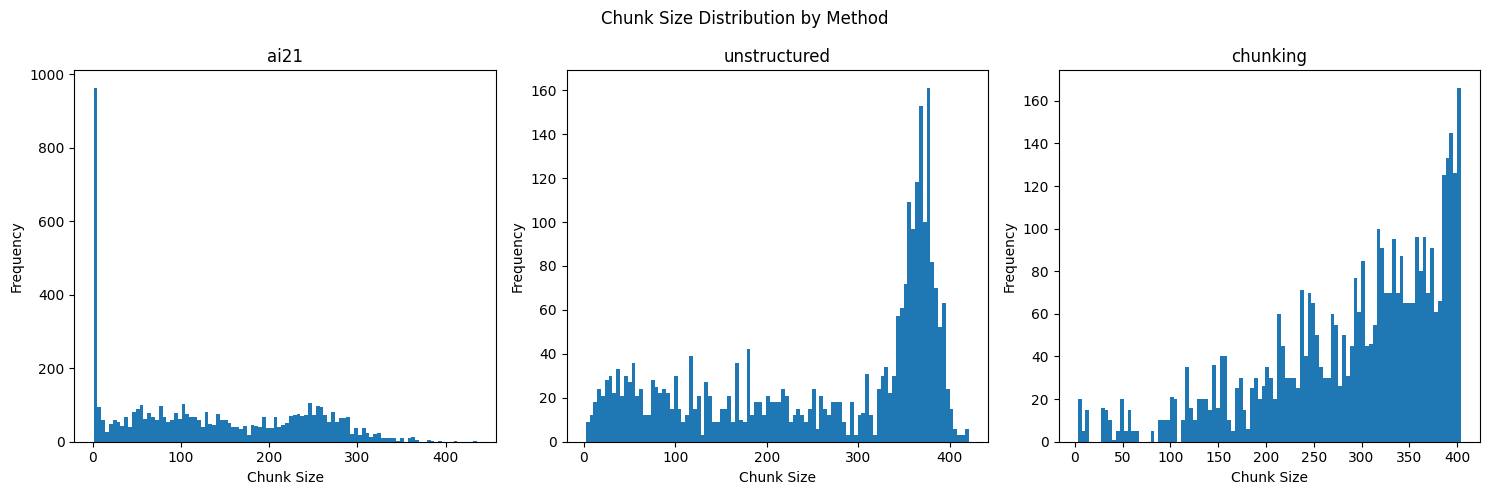

In [13]:
import json
import os
import matplotlib.pyplot as plt
import tiktoken

chunk_methods = os.listdir("chunks")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Chunk Size Distribution by Method')

tokenizer = tiktoken.get_encoding("o200k_base")

for i, chunk_method in enumerate(chunk_methods):    
    with open(f"chunks/{chunk_method}", "r") as f:        
        chunks_with_metadata = json.loads(f.read())                
        axs[i].hist([len(tokenizer.encode(chunk["text"])) for chunk in chunks_with_metadata], bins=100)        
        axs[i].set_title(chunk_method.split(".")[0])
        axs[i].set_xlabel('Chunk Size')
        axs[i].set_ylabel('Frequency')
        
plt.tight_layout()
plt.show()        

## Results

Here are the parameters we used this time around:

| Parameter | Value |
|-----------|-------|
| Chunk size | 400 |
| Rerank buffer size | 1000 |
| Rerank model | "rerank-english-v3.0" |


A chunk size of 400 tokens ("o200k_base" encoding) was chosen to be a good balance between the cost of the embeddings and the amount of context that could be provided to the model. 

We chose a rerank buffer size of 1000, meaning that we first embedded the question to get the top 1000 chunks from the vector database (Pinecone). These chunks were then all passed to the reranker (Cohere) with a `max_chunks_per_doc = 1` to ensure that the reranker would only use the chunks we gave it (and not chunk the chunks again).


### Results for different top k values 
(the number of relevant chunks used as context for the question)

#### Top k = 1

| Method | Percent Correct | Num Correct | Num Questions |
|--------|-----------------|-------------|---------------|
| unstructured.io | 0.32381 | 68 | 210 |
| ai21.com | 0.342857 | 72 | 210 |
| chunking.com | **0.371429** | 78 | 210 |
| baseline | 0.304762 | 64 | 210 |

#### Top k = 2

| Method | Percent Correct | Num Correct | Num Questions |
|--------|-----------------|-------------|---------------|
| unstructured.io | 0.380952 | 80 | 210 |
| ai21.com | 0.385714 | 81 | 210 |
| chunking.com | **0.442857** | 93 | 210 |
| baseline | 0.32381 | 68 | 210 |

#### Top k = 3

| Method | Percent Correct | Num Correct | Num Questions |
|--------|-----------------|-------------|---------------|
| unstructured.io | 0.485714 | 102 | 210 |
| ai21.com | 0.42381 | 89 | 210 |
| chunking.com | **0.514286** | 108 | 210 |
| baseline | 0.309524 | 65 | 210 |

#### Top k = 4

| Method | Percent Correct | Num Correct | Num Questions |
|--------|-----------------|-------------|---------------|
| unstructured.io | 0.528571 | 111 | 210 |
| ai21.com | 0.438095 | 92 | 210 |
| chunking.com | **0.538095** | 113 | 210 |
| baseline | 0.32381 | 68 | 210 |

#### Top k = 5

| Method | Percent Correct | Num Correct | Num Questions |
|--------|-----------------|-------------|---------------|
| unstructured.io | 0.566667 | 119 | 210 |
| ai21.com | 0.457143 | 96 | 210 |
| chunking.com | **0.619048** | 130 | 210 |
| baseline | 0.304762 | 64 | 210 |
